In [2]:
%load_ext autoreload
%autoreload 2

### Imports

In [3]:
import os
import shutil

import numpy as np 
import pandas as pd

import pydicom as dicom
import matplotlib.pyplot as plt

from pathlib import Path

In [4]:
train_dir = Path('E:\data\RSNA2024')

In [5]:
class CFG:
    random_seed = 42
    
    ROOT_FOLDER = train_dir
    IMAGES_DIR = ROOT_FOLDER / 'train_images'
    TRAIN_CSV = ROOT_FOLDER / 'train.csv'
    FILES_CSV = ROOT_FOLDER / 'train_files.csv'
    TRAIN_DESC_CSV = ROOT_FOLDER / 'train_series_descriptions.csv'
    COORDS_CSV = ROOT_FOLDER / 'train_label_coordinates.csv'

### Train data

In [6]:
train_df = pd.read_csv(CFG.TRAIN_CSV)
train_desc_df = pd.read_csv(CFG.TRAIN_DESC_CSV)

train_df.shape, train_desc_df.shape

((1975, 26), (6294, 3))

In [7]:
train_df.head()

study_id SCSL1L2 SCSL2L3 SCSL3L4 SCSL4L5 SCSL5S1 LNFNL1L2 LNFNL2L3  \
0   4003253       N       N       N       N       N        N        N   
1   4646740       N       N       M       S       N        N        N   
2   7143189       N       N       N       N       N        N        N   
3   8785691       N       N       N       N       N        N        N   
4  10728036       N       N       N       N       N        N        N   

  LNFNL3L4 LNFNL4L5  ... LSSL1L2 LSSL2L3 LSSL3L4 LSSL4L5 LSSL5S1 RSSL1L2  \
0        N        M  ...       N       N       N       M       N       N   
1        N        M  ...       N       N       N       S       N       N   
2        N        N  ...       N       N       N       N       N       N   
3        N        M  ...       N       N       N       N       N       N   
4        N        N  ...       N       N       N       N       N       N   

  RSSL2L3 RSSL3L4 RSSL4L5 RSSL5S1  
0       N       N       N       N  
1       M       M       M       N  
2       N       N       N       N  
3       N       N       N       N  
4       N       N       M       N  

[5 rows x 26 columns]

In [8]:
train_df.iloc[1]

study_id    4646740
SCSL1L2           N
SCSL2L3           N
SCSL3L4           M
SCSL4L5           S
SCSL5S1           N
LNFNL1L2          N
LNFNL2L3          N
LNFNL3L4          N
LNFNL4L5          M
LNFNL5S1          M
RNFNL1L2          N
RNFNL2L3          N
RNFNL3L4          M
RNFNL4L5          M
RNFNL5S1          N
LSSL1L2           N
LSSL2L3           N
LSSL3L4           N
LSSL4L5           S
LSSL5S1           N
RSSL1L2           N
RSSL2L3           M
RSSL3L4           M
RSSL4L5           M
RSSL5S1           N
Name: 1, dtype: object

In [9]:
train_df.study_id.nunique()

1975

### Coordinates

In [10]:
coords_df = pd.read_csv(CFG.COORDS_CSV)
files_df = pd.read_csv(CFG.FILES_CSV)

coords_df.shape, files_df.shape

((48692, 18), (147218, 21))

In [11]:
coords_df.condition.nunique(), coords_df.level.nunique()

(5, 5)

In [12]:
coords_df.condition.unique(), coords_df.level.unique()

(array(['SCS', 'RNFN', 'LNFN', 'LSS', 'RSS'], dtype=object),
 array(['L1L2', 'L2L3', 'L3L4', 'L4L5', 'L5S1'], dtype=object))

In [13]:
coords_df.study_id.nunique(), coords_df.series_id.nunique()

(1974, 6291)

In [14]:
# coords_df['id'] = coords_df.apply(lambda row: str(row['study_id']) + str(row['series_id']), axis=1)
train_desc_df['id'] = train_desc_df.apply(lambda row: str(row['study_id']) + str(row['series_id']), axis=1)

In [15]:
coords_df.sample(2)

study_id   series_id  instance condition level           x  \
1039     96439573   296385739        10       SCS  L1L2  268.489301   
13677  1228406967  3868795667        13      LNFN  L5S1  263.938149   

                y                  ss_id               instance_id        cl  \
1039   167.448351     96439573_296385739     96439573_296385739_10   SCSL1L2   
13677  343.835052  1228406967_3868795667  1228406967_3868795667_13  LNFNL5S1   

      series_description  rows  columns  \
1039    Sagittal T2/STIR   512      512   
13677        Sagittal T1   528      512   

                                                filename patientposition  \
1039   E:\data\RSNA2024\pngs_256\96439573_296385739_1...             FFS   
13677  E:\data\RSNA2024\pngs_256\1228406967_386879566...             HFS   

         x_perc    y_perc  inst_perc  
1039   0.524393  0.327048   0.473684  
13677  0.515504  0.651203   0.666667

In [16]:
train_desc_df[train_desc_df['id'] == '4003253702807833'].series_description.values[0]

'Sagittal T2/STIR'

In [17]:
# pd.crosstab(coords_df.plane, coords_df.cl)

#### Conditions/plane crosstab

In [18]:
pd.crosstab(coords_df.condition, coords_df.series_description)

series_description  Axial T2  Sagittal T1  Sagittal T2/STIR
condition                                                  
LNFN                       0         9860                 0
LSS                     9608            0                 0
RNFN                       0         9859                 0
RSS                     9612            0                 0
SCS                        0            5              9748

In [19]:
coords_df.study_id.nunique()

1974

In [20]:
coords_df.groupby('condition').instance_id.nunique()

condition
LNFN    4089
LSS     9608
RNFN    4211
RSS     9612
SCS     2522
Name: instance_id, dtype: int64

In [21]:
# get the positive slices
coords_df.groupby(['study_id','series_id']).instance.unique()

study_id    series_id 
4003253     702807833                              [8]
            1054713880               [4, 5, 6, 11, 12]
            2448190387          [3, 4, 11, 19, 28, 35]
4646740     3201256954    [15, 16, 22, 28, 29, 34, 40]
            3486248476           [5, 6, 7, 15, 16, 17]
                                      ...             
4287160193  1507070277                             [8]
            1820446240          [4, 9, 10, 16, 22, 28]
4290709089  3274612423                             [9]
            3390218084    [2, 3, 5, 6, 10, 15, 20, 21]
            4237840455                  [4, 5, 11, 12]
Name: instance, Length: 6291, dtype: object

In [22]:
# total positive images 
coords_df.instance_id.nunique()

24546

In [23]:
# positive images per patient
grp = coords_df.groupby(['study_id']).instance_id.count()

grp.mean(), grp.min(), grp.max()

(24.666666666666668, 15, 25)

### Train_df

In [24]:
# look at categories
for f in ['condition','level']:
    print(coords_df[f].value_counts())
    print('-'*50);print();

condition
LNFN    9860
RNFN    9859
SCS     9753
RSS     9612
LSS     9608
Name: count, dtype: int64
--------------------------------------------------

level
L3L4    9858
L4L5    9858
L5S1    9845
L2L3    9661
L1L2    9470
Name: count, dtype: int64
--------------------------------------------------



In [25]:
# pd.crosstab(coords_df.condition, coords_df.level)

### Files

In [26]:
files_df.head(3)

study_id   series_id  image  proj  instancenumber  rows  columns  \
0  100206310  1012284084      1  -394               1   320      320   
1  100206310  1012284084     10  -427              10   320      320   
2  100206310  1012284084     11  -431              11   320      320   

   slicethickness  spacingbetweenslices patientposition  ...  \
0             3.5                   3.5             HFS  ...   
1             3.5                   3.5             HFS  ...   
2             3.5                   3.5             HFS  ...   

                  ss_id              instance_id  \
0  100206310_1012284084   100206310_1012284084_1   
1  100206310_1012284084  100206310_1012284084_10   
2  100206310_1012284084  100206310_1012284084_11   

                                            filename series_description cl  \
0  E:\data\RSNA2024\pngs_256\100206310_1012284084...           Axial T2  H   
1  E:\data\RSNA2024\pngs_256\100206310_1012284084...           Axial T2  H   
2  E:\data\RSNA2024\pngs_256\100206310_1012284084...           Axial T2  H   

  condition inst_min  inst_max  inst  inst_perc  
0         H        1        60     0   0.000000  
1         H        1        60     9   0.150000  
2         H        1        60    10   0.166667  

[3 rows x 21 columns]

In [27]:
files_df.groupby('study_id').instance_id.count().agg(['min', 'max', 'mean'])

min      37.000000
max     247.000000
mean     74.540759
Name: instance_id, dtype: float64

In [28]:
files_df.rows.min(), files_df.rows.max(), files_df['columns'].min(), files_df['columns'].max(), 

(192, 1024, 224, 1024)

In [29]:
# files_df.image.max(), files_df.image.mean()

In [30]:
# file names do not correspond to file count
files_df[files_df.image == 5049]

study_id   series_id  image  proj  instancenumber  rows  columns  \
59719  2581283971  2683794967   5049  -208            5049   320      320   

       slicethickness  spacingbetweenslices patientposition  ...  \
59719             4.0                   5.0             FFS  ...   

                       ss_id                 instance_id  \
59719  2581283971_2683794967  2581283971_2683794967_5049   

                                                filename series_description  \
59719  E:\data\RSNA2024\pngs_256\2581283971_268379496...           Axial T2   

      cl condition inst_min  inst_max  inst  inst_perc  
59719  H         H        1      5049  5048   0.999802  

[1 rows x 21 columns]

#### Patient positions

In [31]:
files_df.patientposition.unique()

array(['HFS', 'FFS'], dtype=object)

In [32]:
files_df.patientposition.value_counts()

patientposition
HFS    118249
FFS     28969
Name: count, dtype: int64

In [33]:
files_df.groupby(['study_id']).patientposition.unique().value_counts()

patientposition
[HFS]    1585
[FFS]     390
Name: count, dtype: int64

#### Studies with multiple series

In [34]:
# some studies have more series
grp = files_df.groupby('study_id').filter(lambda group: group.series_id.nunique() > 3).study_id
multi_studies = grp.unique().tolist()
grp.nunique(), len(multi_studies), files_df.study_id.nunique()

(340, 340, 1975)

In [35]:
files_df.series_description.value_counts()

series_description
Axial T2            79979
Sagittal T1         33670
Sagittal T2/STIR    33569
Name: count, dtype: int64

In [36]:
study_id = multi_studies[1]
print(study_id)
files_df[files_df['study_id'] == study_id]

1018005303


study_id   series_id  image  proj  instancenumber  rows  columns  \
672  1018005303  1049505285      1    84               1   320      320   
673  1018005303  1049505285     10     7              10   320      320   
674  1018005303  1049505285     11     3              11   320      320   
675  1018005303  1049505285     12     0              12   320      320   
676  1018005303  1049505285     13   -25              13   320      320   
..          ...         ...    ...   ...             ...   ...      ...   
789  1018005303  4193900495      5   -40               5   256      256   
790  1018005303  4193900495      6   -45               6   256      256   
791  1018005303  4193900495      7   -49               7   256      256   
792  1018005303  4193900495      8   -54               8   256      256   
793  1018005303  4193900495      9   -58               9   256      256   

     slicethickness  spacingbetweenslices patientposition  ...  \
672             4.0                   4.4             HFS  ...   
673             4.0                   4.4             HFS  ...   
674             4.0                   4.4             HFS  ...   
675             4.0                   4.4             HFS  ...   
676             4.0                   4.4             HFS  ...   
..              ...                   ...             ...  ...   
789             4.0                   4.4             HFS  ...   
790             4.0                   4.4             HFS  ...   
791             4.0                   4.4             HFS  ...   
792             4.0                   4.4             HFS  ...   
793             4.0                   4.4             HFS  ...   

                     ss_id               instance_id  \
672  1018005303_1049505285   1018005303_1049505285_1   
673  1018005303_1049505285  1018005303_1049505285_10   
674  1018005303_1049505285  1018005303_1049505285_11   
675  1018005303_1049505285  1018005303_1049505285_12   
676  1018005303_1049505285  1018005303_1049505285_13   
..                     ...                       ...   
789  1018005303_4193900495   1018005303_4193900495_5   
790  1018005303_4193900495   1018005303_4193900495_6   
791  1018005303_4193900495   1018005303_4193900495_7   
792  1018005303_4193900495   1018005303_4193900495_8   
793  1018005303_4193900495   1018005303_4193900495_9   

                                              filename series_description cl  \
672  E:\data\RSNA2024\pngs_256\1018005303_104950528...           Axial T2  H   
673  E:\data\RSNA2024\pngs_256\1018005303_104950528...           Axial T2  H   
674  E:\data\RSNA2024\pngs_256\1018005303_104950528...           Axial T2  H   
675  E:\data\RSNA2024\pngs_256\1018005303_104950528...           Axial T2  H   
676  E:\data\RSNA2024\pngs_256\1018005303_104950528...           Axial T2  H   
..                                                 ...                ... ..   
789  E:\data\RSNA2024\pngs_256\1018005303_419390049...           Axial T2  H   
790  E:\data\RSNA2024\pngs_256\1018005303_419390049...           Axial T2  H   
791  E:\data\RSNA2024\pngs_256\1018005303_419390049...           Axial T2  H   
792  E:\data\RSNA2024\pngs_256\1018005303_419390049...           Axial T2  H   
793  E:\data\RSNA2024\pngs_256\1018005303_419390049...           Axial T2  H   

    condition inst_min  inst_max  inst  inst_perc  
672         H        1        24     0   0.000000  
673         H        1        24     9   0.375000  
674         H        1        24    10   0.416667  
675         H        1        24    11   0.458333  
676         H        1        24    12   0.500000  
..        ...      ...       ...   ...        ...  
789         H        1        30     4   0.133333  
790         H        1        30     5   0.166667  
791         H        1        30     6   0.200000  
792         H        1        30     7   0.233333  
793         H        1        30     8   0.266667  

[122 rows x 21 columns]

#### positive/total images

In [37]:
# study_id = multi_studies[1]
# study 1018005303 has multiple axial series
study_id = 1018005303
print(study_id)
files_df[files_df['study_id'] == study_id].groupby('series_id').series_description.value_counts()

1018005303


series_id   series_description
1049505285  Axial T2              24
1131788901  Sagittal T2/STIR      18
3398516088  Sagittal T1           18
3675524442  Axial T2              32
4193900495  Axial T2              30
Name: count, dtype: int64

In [38]:
coords_df[coords_df['study_id'] == study_id].groupby('series_id').instance.count()

series_id
1049505285     5
1131788901     5
3398516088    10
3675524442     2
4193900495     3
Name: instance, dtype: int64

In [39]:
coords_df[coords_df['study_id'] == study_id].groupby('series_id').cl.unique()

series_id
1049505285        [RSSL1L2, RSSL2L3, RSSL3L4, RSSL4L5, RSSL5S1]
1131788901        [SCSL1L2, SCSL2L3, SCSL3L4, SCSL4L5, SCSL5S1]
3398516088    [RNFNL5S1, RNFNL1L2, RNFNL2L3, RNFNL3L4, RNFNL...
3675524442                                   [LSSL1L2, LSSL2L3]
4193900495                          [LSSL3L4, LSSL4L5, LSSL5S1]
Name: cl, dtype: object

In [40]:
coords_df[coords_df['study_id'] == study_id].groupby('series_id').condition.unique()

series_id
1049505285           [RSS]
1131788901           [SCS]
3398516088    [RNFN, LNFN]
3675524442           [LSS]
4193900495           [LSS]
Name: condition, dtype: object

#### Positive labels

In [41]:
coords_df[(coords_df['study_id'] == study_id) & (coords_df['series_description'] == 'Axial T2')]

study_id   series_id  instance condition level           x  \
11471  1018005303  1049505285         7       RSS  L1L2  136.863376   
11472  1018005303  1049505285        10       RSS  L2L3  144.210426   
11473  1018005303  1049505285        14       RSS  L3L4  145.796155   
11474  1018005303  1049505285        18       RSS  L4L5  145.796155   
11475  1018005303  1049505285        22       RSS  L5S1  143.258989   
11491  1018005303  3675524442        12       LSS  L1L2  136.382301   
11492  1018005303  3675524442        20       LSS  L2L3  134.116814   
11493  1018005303  4193900495         3       LSS  L3L4  135.023009   
11494  1018005303  4193900495        11       LSS  L4L5  135.929204   
11495  1018005303  4193900495        18       LSS  L5S1  139.100885   

                y                  ss_id               instance_id       cl  \
11471  168.469242  1018005303_1049505285   1018005303_1049505285_7  RSSL1L2   
11472  171.840932  1018005303_1049505285  1018005303_1049505285_10  RSSL2L3   
11473  168.035183  1018005303_1049505285  1018005303_1049505285_14  RSSL3L4   
11474  168.669475  1018005303_1049505285  1018005303_1049505285_18  RSSL4L5   
11475  167.718038  1018005303_1049505285  1018005303_1049505285_22  RSSL5S1   
11491  143.745133  1018005303_3675524442  1018005303_3675524442_12  LSSL1L2   
11492  141.932743  1018005303_3675524442  1018005303_3675524442_20  LSSL2L3   
11493  153.260177  1018005303_4193900495   1018005303_4193900495_3  LSSL3L4   
11494  151.447788  1018005303_4193900495  1018005303_4193900495_11  LSSL4L5   
11495  146.916814  1018005303_4193900495  1018005303_4193900495_18  LSSL5S1   

      series_description  rows  columns  \
11471           Axial T2   320      320   
11472           Axial T2   320      320   
11473           Axial T2   320      320   
11474           Axial T2   320      320   
11475           Axial T2   320      320   
11491           Axial T2   256      256   
11492           Axial T2   256      256   
11493           Axial T2   256      256   
11494           Axial T2   256      256   
11495           Axial T2   256      256   

                                                filename patientposition  \
11471  E:\data\RSNA2024\pngs_256\1018005303_104950528...             HFS   
11472  E:\data\RSNA2024\pngs_256\1018005303_104950528...             HFS   
11473  E:\data\RSNA2024\pngs_256\1018005303_104950528...             HFS   
11474  E:\data\RSNA2024\pngs_256\1018005303_104950528...             HFS   
11475  E:\data\RSNA2024\pngs_256\1018005303_104950528...             HFS   
11491  E:\data\RSNA2024\pngs_256\1018005303_367552444...             HFS   
11492  E:\data\RSNA2024\pngs_256\1018005303_367552444...             HFS   
11493  E:\data\RSNA2024\pngs_256\1018005303_419390049...             HFS   
11494  E:\data\RSNA2024\pngs_256\1018005303_419390049...             HFS   
11495  E:\data\RSNA2024\pngs_256\1018005303_419390049...             HFS   

         x_perc    y_perc  inst_perc  
11471  0.427698  0.526466   0.250000  
11472  0.450658  0.537003   0.375000  
11473  0.455613  0.525110   0.541667  
11474  0.455613  0.527092   0.708333  
11475  0.447684  0.524119   0.875000  
11491  0.532743  0.561504   0.343750  
11492  0.523894  0.554425   0.593750  
11493  0.527434  0.598673   0.066667  
11494  0.530973  0.591593   0.333333  
11495  0.543363  0.573894   0.566667

In [42]:
# files_df[(files_df['study_id'] == study_id) & (files_df['series_description'] == 'Axial T2')].sort_values(['series_id', 'image'])[50:]

In [43]:
# max/mean images per patient
grp = files_df.groupby(['study_id','series_id']).image.count()
grp.min(), grp.max(), grp.mean()

(5, 192, 23.390212901175722)

In [44]:
# mean positive imgs per series
grp = coords_df.groupby(['study_id'])
grp.instance_id.nunique().mean(), grp.instance_id.nunique().max(), grp.instance_id.nunique().min()

(12.434650455927052, 22, 6)

In [45]:
# mean positive imgs per series
coords_df.groupby(['study_id','series_id']).instance_id.nunique().mean()

3.9017644253695756

In [46]:
# img per series
coords_df.groupby(['study_id','series_id']).instance_id.count().mean()

7.739945954538229

In [47]:
files_df.groupby(['study_id','series_id']).series_id.count()

study_id    series_id 
4003253     702807833     15
            1054713880    15
            2448190387    43
4646740     3201256954    54
            3486248476    17
                          ..
4287160193  1507070277    15
            1820446240    42
4290709089  3274612423    15
            3390218084    23
            4237840455    15
Name: series_id, Length: 6294, dtype: int64

### Analyze one example

In [48]:
patient = 4003253
train_df[train_df['study_id'] == patient].iloc[0]

study_id    4003253
SCSL1L2           N
SCSL2L3           N
SCSL3L4           N
SCSL4L5           N
SCSL5S1           N
LNFNL1L2          N
LNFNL2L3          N
LNFNL3L4          N
LNFNL4L5          M
LNFNL5S1          N
RNFNL1L2          N
RNFNL2L3          N
RNFNL3L4          M
RNFNL4L5          M
RNFNL5S1          N
LSSL1L2           N
LSSL2L3           N
LSSL3L4           N
LSSL4L5           M
LSSL5S1           N
RSSL1L2           N
RSSL2L3           N
RSSL3L4           N
RSSL4L5           N
RSSL5S1           N
Name: 0, dtype: object

In [49]:
coords_df[coords_df['study_id'] == patient].condition.unique()

array(['SCS', 'RNFN', 'LNFN', 'LSS', 'RSS'], dtype=object)

In [50]:
coords_df[coords_df['study_id'] == patient][['instance', 'cl', 'condition']]

instance        cl condition
0          8   SCSL1L2       SCS
1          8   SCSL2L3       SCS
2          8   SCSL3L4       SCS
3          8   SCSL4L5       SCS
4          8   SCSL5S1       SCS
5          4  RNFNL4L5      RNFN
6          4  RNFNL5S1      RNFN
7          5  RNFNL3L4      RNFN
8          6  RNFNL1L2      RNFN
9          6  RNFNL2L3      RNFN
10        11  LNFNL1L2      LNFN
11        11  LNFNL4L5      LNFN
12        11  LNFNL5S1      LNFN
13        12  LNFNL2L3      LNFN
14        12  LNFNL3L4      LNFN
15         3   LSSL1L2       LSS
16         4   RSSL1L2       RSS
17        11   LSSL2L3       LSS
18        11   RSSL2L3       RSS
19        19   LSSL3L4       LSS
20        19   RSSL3L4       RSS
21        28   LSSL4L5       LSS
22        28   RSSL4L5       RSS
23        35   LSSL5S1       LSS
24        35   RSSL5S1       RSS

### Order

In [51]:
files_df.sample(2)

study_id   series_id  image  proj  instancenumber  rows  columns  \
5032   1119763924   926922520     21  -492              21   640      640   
51216  2361533111  2353320483     26   -59              26   320      320   

       slicethickness  spacingbetweenslices patientposition  ...  \
5032              3.5                   3.5             HFS  ...   
51216             4.0                   4.4             HFS  ...   

                       ss_id               instance_id  \
5032    1119763924_926922520   1119763924_926922520_21   
51216  2361533111_2353320483  2361533111_2353320483_26   

                                                filename series_description  \
5032   E:\data\RSNA2024\pngs_256\1119763924_926922520...           Axial T2   
51216  E:\data\RSNA2024\pngs_256\2361533111_235332048...           Axial T2   

      cl condition inst_min  inst_max  inst  inst_perc  
5032   H         H        1        43    20   0.465116  
51216  H         H        1        42    25   0.595238  

[2 rows x 21 columns]

In [52]:
study = 1018005303

df = files_df[files_df['study_id'] == study]

df.shape

(122, 21)

In [54]:
df.series_description.unique()

array(['Axial T2', 'Sagittal T2/STIR', 'Sagittal T1'], dtype=object)

In [59]:
df[df['series_description'] == 'Sagittal T2/STIR'].sort_values(['series_id', 'proj'], ascending=[True, False])[:60]

study_id   series_id  image  proj  instancenumber  rows  columns  \
696  1018005303  1131788901      1    32               1   384      384   
706  1018005303  1131788901      2    28               2   384      384   
707  1018005303  1131788901      3    24               3   384      384   
708  1018005303  1131788901      4    20               4   384      384   
709  1018005303  1131788901      5    16               5   384      384   
710  1018005303  1131788901      6    12               6   384      384   
711  1018005303  1131788901      7     8               7   384      384   
712  1018005303  1131788901      8     4               8   384      384   
713  1018005303  1131788901      9     0               9   384      384   
697  1018005303  1131788901     10    -3              10   384      384   
698  1018005303  1131788901     11    -7              11   384      384   
699  1018005303  1131788901     12   -11              12   384      384   
700  1018005303  1131788901     13   -15              13   384      384   
701  1018005303  1131788901     14   -19              14   384      384   
702  1018005303  1131788901     15   -23              15   384      384   
703  1018005303  1131788901     16   -27              16   384      384   
704  1018005303  1131788901     17   -31              17   384      384   
705  1018005303  1131788901     18   -35              18   384      384   

     slicethickness  spacingbetweenslices patientposition  ...  \
696             4.0                   4.0             HFS  ...   
706             4.0                   4.0             HFS  ...   
707             4.0                   4.0             HFS  ...   
708             4.0                   4.0             HFS  ...   
709             4.0                   4.0             HFS  ...   
710             4.0                   4.0             HFS  ...   
711             4.0                   4.0             HFS  ...   
712             4.0                   4.0             HFS  ...   
713             4.0                   4.0             HFS  ...   
697             4.0                   4.0             HFS  ...   
698             4.0                   4.0             HFS  ...   
699             4.0                   4.0             HFS  ...   
700             4.0                   4.0             HFS  ...   
701             4.0                   4.0             HFS  ...   
702             4.0                   4.0             HFS  ...   
703             4.0                   4.0             HFS  ...   
704             4.0                   4.0             HFS  ...   
705             4.0                   4.0             HFS  ...   

                     ss_id               instance_id  \
696  1018005303_1131788901   1018005303_1131788901_1   
706  1018005303_1131788901   1018005303_1131788901_2   
707  1018005303_1131788901   1018005303_1131788901_3   
708  1018005303_1131788901   1018005303_1131788901_4   
709  1018005303_1131788901   1018005303_1131788901_5   
710  1018005303_1131788901   1018005303_1131788901_6   
711  1018005303_1131788901   1018005303_1131788901_7   
712  1018005303_1131788901   1018005303_1131788901_8   
713  1018005303_1131788901   1018005303_1131788901_9   
697  1018005303_1131788901  1018005303_1131788901_10   
698  1018005303_1131788901  1018005303_1131788901_11   
699  1018005303_1131788901  1018005303_1131788901_12   
700  1018005303_1131788901  1018005303_1131788901_13   
701  1018005303_1131788901  1018005303_1131788901_14   
702  1018005303_1131788901  1018005303_1131788901_15   
703  1018005303_1131788901  1018005303_1131788901_16   
704  1018005303_1131788901  1018005303_1131788901_17   
705  1018005303_1131788901  1018005303_1131788901_18   

                                              filename series_description cl  \
696  E:\data\RSNA2024\pngs_256\1018005303_113178890...   Sagittal T2/STIR  H   
706  E:\data\RSNA2024\pngs_256\1018005303_113178890...   Sagittal T2/STIR  H   
707  E:\data\RSNA2024

In [51]:
df[df['series_description'] == 'Axial T2'].sort_values(['series_id', 'proj'], ascending=[True, False])[:60]

study_id   series_id  image  proj  instancenumber  rows  columns  \
672  1018005303  1049505285      1    84               1   320      320   
683  1018005303  1049505285      2    80               2   320      320   
689  1018005303  1049505285      3    76               3   320      320   
690  1018005303  1049505285      4    71               4   320      320   
691  1018005303  1049505285      5    50               5   320      320   
692  1018005303  1049505285      6    46               6   320      320   
693  1018005303  1049505285      7    41               7   320      320   
694  1018005303  1049505285      8    37               8   320      320   
695  1018005303  1049505285      9    12               9   320      320   
673  1018005303  1049505285     10     7              10   320      320   
674  1018005303  1049505285     11     3              11   320      320   
675  1018005303  1049505285     12     0              12   320      320   
676  1018005303  1049505285     13   -25              13   320      320   
677  1018005303  1049505285     14   -29              14   320      320   
678  1018005303  1049505285     15   -34              15   320      320   
679  1018005303  1049505285     16   -38              16   320      320   
680  1018005303  1049505285     17   -61              17   320      320   
681  1018005303  1049505285     18   -65              18   320      320   
682  1018005303  1049505285     19   -69              19   320      320   
684  1018005303  1049505285     20   -74              20   320      320   
685  1018005303  1049505285     21   -94              21   320      320   
686  1018005303  1049505285     22   -98              22   320      320   
687  1018005303  1049505285     23  -103              23   320      320   
688  1018005303  1049505285     24  -107              24   320      320   
732  1018005303  3675524442      1    89               1   256      256   
743  1018005303  3675524442      2    85               2   256      256   
754  1018005303  3675524442      3    80               3   256      256   
758  1018005303  3675524442      4    76               4   256      256   
759  1018005303  3675524442      5    71               5   256      256   
760  1018005303  3675524442      6    67               6   256      256   
761  1018005303  3675524442      7    63               7   256      256   
762  1018005303  3675524442      8    58               8   256      256   
763  1018005303  3675524442      9    54               9   256      256   
733  1018005303  3675524442     10    49              10   256      256   
734  1018005303  3675524442     11    45              11   256      256   
735  1018005303  3675524442     12    41              12   256      256   
736  1018005303  3675524442     13    36              13   256      256   
737  1018005303  3675524442     14    32              14   256      256   
738  1018005303  3675524442     15    27              15   256      256   
739  1018005303  3675524442     16    23              16   256      256   
740  1018005303  3675524442     17    19              17   256      256   
741  1018005303  3675524442     18    14              18   256      256   
742  1018005303  3675524442     19    10              19   256      256   
744  1018005303  3675524442     20     5              20   256      256   
745  1018005303  3675524442     21     1              21   256      256   
746  1018005303  3675524442     22    -2              22   256      256   
747  1018005303  3675524442     23    -7              23   256      256   
748  1018005303  3675524442     24   -11              24   256      256   
749  1018005303  3675524442     25   -16              25   256      256   
750  1018005303  3675524442     26   -20              26   256      256   
751  1018005303  3675524442     27   -24              27   256      256   
752  1018005303  3675524442     28   -29              28   256      256   
753  1018005303  3675524442     

In [52]:
df[df['series_description'] == 'Axial T2'].sort_values(['proj'], ascending=[False])[:60]

study_id   series_id  image  proj  instancenumber  rows  columns  \
732  1018005303  3675524442      1    89               1   256      256   
743  1018005303  3675524442      2    85               2   256      256   
672  1018005303  1049505285      1    84               1   320      320   
683  1018005303  1049505285      2    80               2   320      320   
754  1018005303  3675524442      3    80               3   256      256   
689  1018005303  1049505285      3    76               3   320      320   
758  1018005303  3675524442      4    76               4   256      256   
690  1018005303  1049505285      4    71               4   320      320   
759  1018005303  3675524442      5    71               5   256      256   
760  1018005303  3675524442      6    67               6   256      256   
761  1018005303  3675524442      7    63               7   256      256   
762  1018005303  3675524442      8    58               8   256      256   
763  1018005303  3675524442      9    54               9   256      256   
691  1018005303  1049505285      5    50               5   320      320   
733  1018005303  3675524442     10    49              10   256      256   
692  1018005303  1049505285      6    46               6   320      320   
734  1018005303  3675524442     11    45              11   256      256   
693  1018005303  1049505285      7    41               7   320      320   
735  1018005303  3675524442     12    41              12   256      256   
694  1018005303  1049505285      8    37               8   320      320   
736  1018005303  3675524442     13    36              13   256      256   
737  1018005303  3675524442     14    32              14   256      256   
738  1018005303  3675524442     15    27              15   256      256   
739  1018005303  3675524442     16    23              16   256      256   
740  1018005303  3675524442     17    19              17   256      256   
741  1018005303  3675524442     18    14              18   256      256   
695  1018005303  1049505285      9    12               9   320      320   
742  1018005303  3675524442     19    10              19   256      256   
673  1018005303  1049505285     10     7              10   320      320   
744  1018005303  3675524442     20     5              20   256      256   
674  1018005303  1049505285     11     3              11   320      320   
745  1018005303  3675524442     21     1              21   256      256   
675  1018005303  1049505285     12     0              12   320      320   
746  1018005303  3675524442     22    -2              22   256      256   
747  1018005303  3675524442     23    -7              23   256      256   
748  1018005303  3675524442     24   -11              24   256      256   
749  1018005303  3675524442     25   -16              25   256      256   
750  1018005303  3675524442     26   -20              26   256      256   
764  1018005303  4193900495      1   -23               1   256      256   
751  1018005303  3675524442     27   -24              27   256      256   
676  1018005303  1049505285     13   -25              13   320      320   
775  1018005303  4193900495      2   -27               2   256      256   
752  1018005303  3675524442     28   -29              28   256      256   
677  1018005303  1049505285     14   -29              14   320      320   
786  1018005303  4193900495      3   -32               3   256      256   
753  1018005303  3675524442     29   -33              29   256      256   
678  1018005303  1049505285     15   -34              15   320      320   
788  1018005303  4193900495      4   -36               4   256      256   
679  1018005303  1049505285     16   -38              16   320      320   
755  1018005303  3675524442     30   -38              30   256      256   
789  1018005303  4193900495      5   -40               5   256      256   
756  1018005303  3675524442     31   -42              31   256      256   
790  1018005303  4193900495     

In [53]:
selection = df[df['series_description'] == 'Axial T2'].sort_values(['proj'], ascending=[False])

selection.study_id.unique()[0]

1018005303

In [54]:
selection.shape

(86, 21)

In [55]:
selection = df[df['series_description'] == 'Axial T2'].sort_values(['proj'], ascending=[False]).reset_index(drop=True)
# dcoms = selection.filename.to_list()


dest_dir = Path('E:\\data\\RSNA2024\\train_images') / str(selection.study_id.unique()[0])

# dest = ('\\').join(dcoms[0].split('\\')[:-1] + ['joined'])

dest_dir

if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)


for i, row in selection.iterrows():
    src = dest_dir / f'{row["series_id"]}'/ f'{row["image"]}.dcm'
    dest = dest_dir / 'joined' / f'{i}.dcm'
    
    shutil.copy(src, dest)

### Visualisations

In [56]:
files_df.patientposition.isna().sum()

0

In [57]:
files_df.groupby(['study_id']).patientposition.unique().value_counts()

patientposition
[HFS]    1585
[FFS]     390
Name: count, dtype: int64

In [58]:
files_df.seriesdescription.unique()

array(['T2', 'T1', nan, 'STIR'], dtype=object)

In [59]:
files_df.seriesdescription.value_counts(), files_df.seriesdescription.isna().sum()

(seriesdescription
 T2      96723
 T1      27688
 STIR       14
 Name: count, dtype: int64,
 22793)

In [60]:
files_df.sample(1)

study_id  series_id  image  proj  instancenumber  rows  columns  \
42792  2148339078  511435220     40   -90              40   512      512   

       slicethickness  spacingbetweenslices patientposition  ...  \
42792             4.0                   5.0             HFS  ...   

                      ss_id              instance_id  \
42792  2148339078_511435220  2148339078_511435220_40   

                                                filename series_description  \
42792  E:\data\RSNA2024\pngs_256\2148339078_511435220...           Axial T2   

      cl condition inst_min  inst_max  inst  inst_perc  
42792  H         H        1        43    39   0.906977  

[1 rows x 21 columns]

In [61]:
coords_df.series_description.unique(), files_df.seriesdescription.unique()

(array(['Sagittal T2/STIR', 'Sagittal T1', 'Axial T2'], dtype=object),
 array(['T2', 'T1', nan, 'STIR'], dtype=object))

In [62]:
coords_df[(coords_df['study_id'] == 1883368654) & (coords_df['series_description'] == 'Sagittal T1')].sample()

study_id   series_id  instance condition level          x  \
21114  1883368654  2427085781        15      LNFN  L5S1  146.77973   

                y                  ss_id               instance_id        cl  \
21114  240.425602  1883368654_2427085781  1883368654_2427085781_15  LNFNL5S1   

      series_description  rows  columns  \
21114        Sagittal T1   340      320   

                                                filename patientposition  \
21114  E:\data\RSNA2024\pngs_256\1883368654_242708578...             HFS   

         x_perc    y_perc  inst_perc  
21114  0.458687  0.707134        0.7

#### Patient position

In [63]:
def get_dcoms(study_id, source=CFG.IMAGES_DIR):
    files = []

    # for t in ['T1', 'T2']:
    for t in ['Sagittal T1', 'Axial T2']:
        # samp = files_df[(files_df['study_id'] == study_id) & (files_df['seriesdescription'] == t)].sample(1)
        samp = coords_df[(coords_df['study_id'] == study_id) & (coords_df['series_description'] == t)].sample(1) 
        series_id = samp.series_id.values[0]
        
        samp = files_df[(files_df['study_id'] == study_id) & (files_df['series_id'] == series_id)].sample(1)
        image = samp.image.values[0]
    
        filename = source / str(study_id) / str(series_id) / f'{image}.dcm'

        files.append(filename)

    return files
    

def plot_dcom(files, title='title'):
    cols = 5
    rows = len(files) // cols +1
    if len(files) < cols:
        cols = len(files) % cols
        # rows += 1

    fig, axs = plt.subplots(rows, cols, figsize=(15, 3*rows))
    fig.suptitle(title)

    for idx, ax in enumerate(axs.flat):
        if idx +  1 > len(files):
            break

        ax.margins(0, 0)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
        ds = dicom.dcmread(files[idx])
        img = ds.pixel_array

        # img = (img - img.min()) / (img.max() - img.min())

        if ds.PhotometricInterpretation == "MONOCHROME1":
            img = 1 - img
    
        ax.imshow(img, cmap="gray")

    plt.show()

In [64]:
hfs = files_df[files_df['patientposition'] == 'HFS'].sample(1).study_id.values[0]
ffs = files_df[files_df['patientposition'] == 'FFS'].sample(1).study_id.values[0]

hfs, ffs

(2780132468, 3563559233)

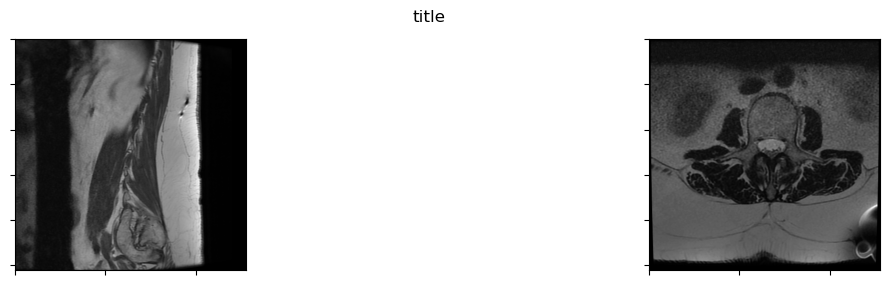

In [65]:
study = 665627263
files = get_dcoms(ffs)

plot_dcom(files)

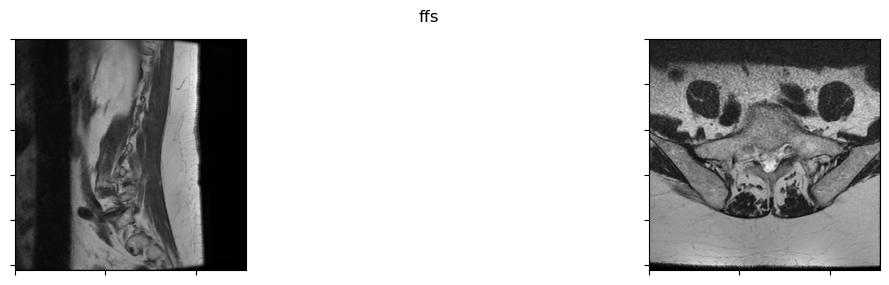

In [66]:
files = get_dcoms(ffs)
plot_dcom(files, title='ffs')

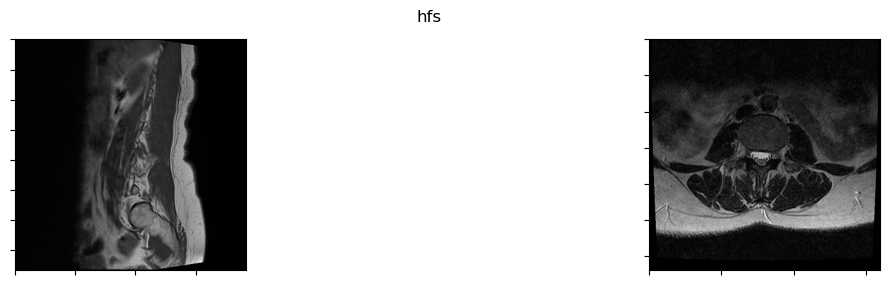

In [78]:
files = get_dcoms(hfs)
plot_dcom(files, title='hfs')

#### Sorting

In [68]:
study_id = files_df.sample(1).study_id.values[0]

study_id

982484811

In [69]:
series_id = files_df[files_df['study_id'] == study_id].sample(1).series_id.values[0]

series_id

3065093922

In [70]:
imgs = files_df[files_df['series_id'] == 1482718348].image.to_list()

In [71]:
def plot_series(study_id, source=CFG.IMAGES_DIR):
    series_id = files_df[files_df['study_id'] == study_id].sample(1).series_id.values[0]

    imgs = files_df[files_df['series_id'] == series_id].image.to_list()
    imgs.sort()

    files = [source / str(study_id) / str(series_id) / f'{image}.dcm' for image in imgs]

    plot_dcom(files, title=f'{series_id} {len(files)} images')

def plot_df(df, source=CFG.IMAGES_DIR):
    files = [source / str(row.study_id) / str(row.series_id) / f'{row.image}.dcm' for _, row in df.iterrows()]

    plot_dcom(files, title=f'{series_id} {len(files)} images')

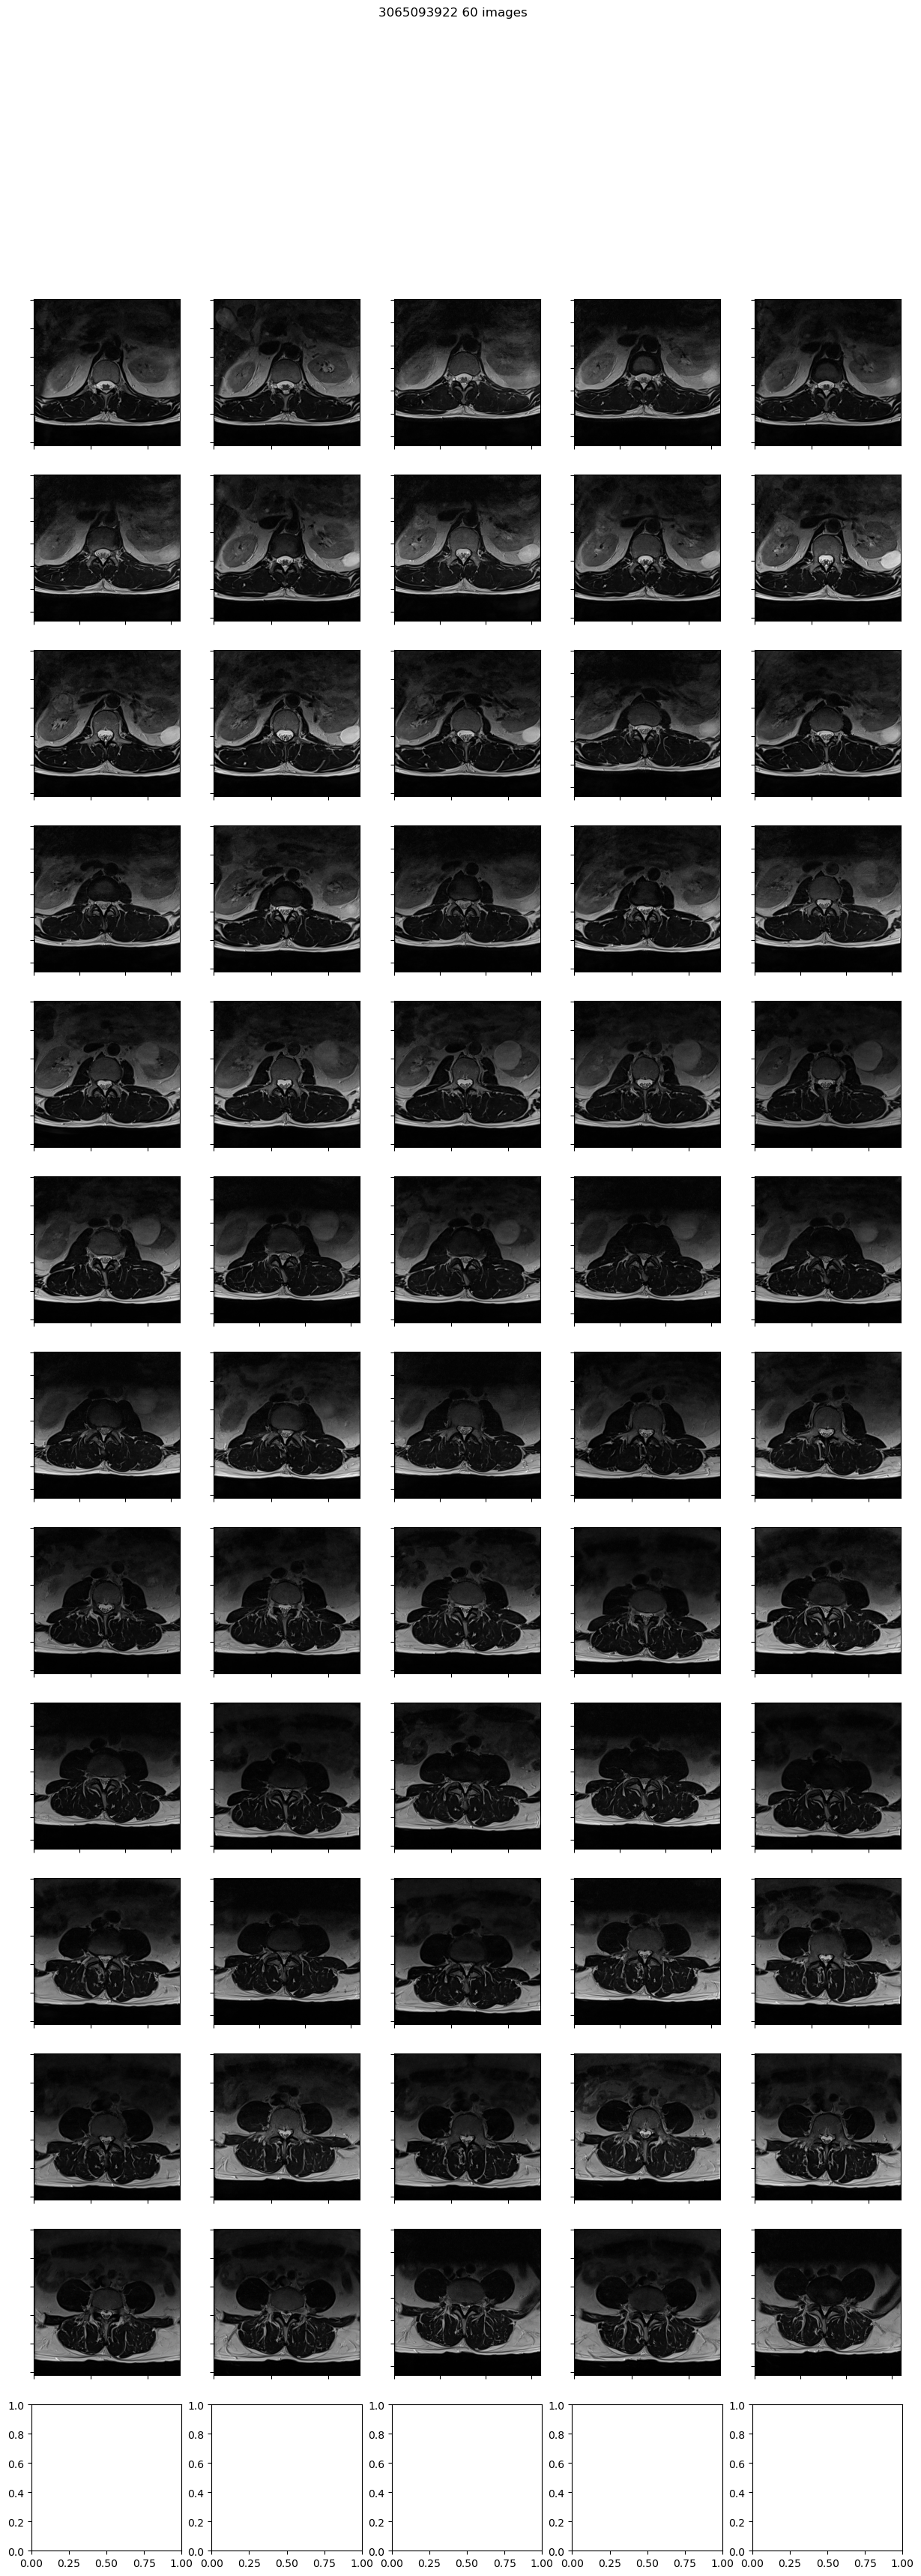

In [72]:
study = 1018005303
df = files_df[files_df['study_id'] == study]

df = df[df['series_description'] == 'Axial T2'].sort_values(['proj'], ascending=[False])[:60]

plot_df(df)

In [73]:
hfs = files_df[files_df['patientposition'] == 'HFS'].sample(1).study_id.values[0]
ffs = files_df[files_df['patientposition'] == 'FFS'].sample(1).study_id.values[0]

hfs, ffs

(2790742955, 416503281)

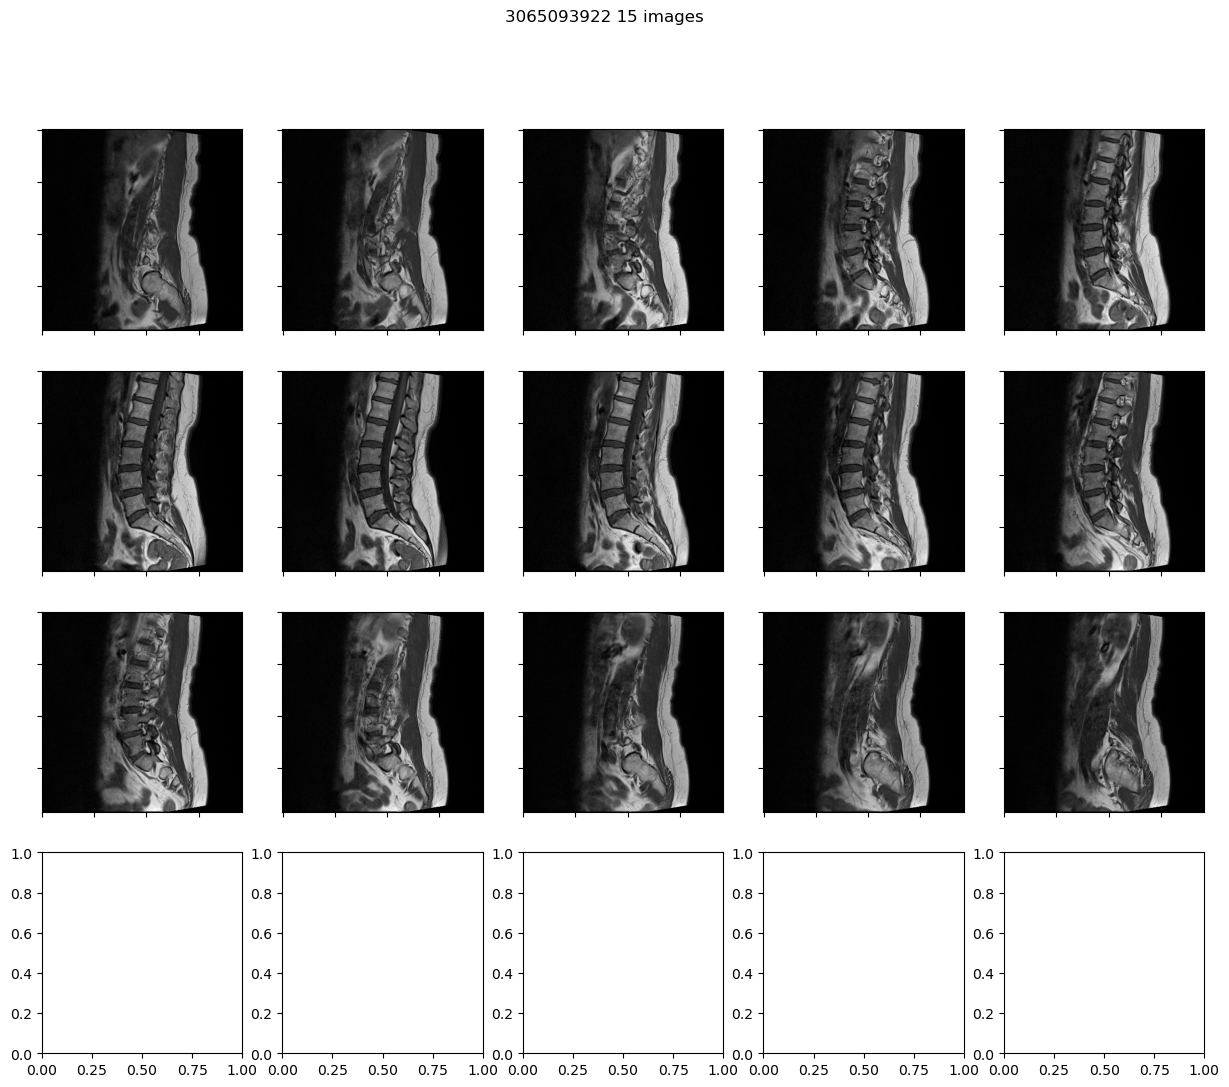

In [74]:
df = files_df[files_df['study_id'] == hfs]

df = df[df['series_description'] == 'Sagittal T1'].sort_values(['proj'], ascending=[False])[:60]

plot_df(df)

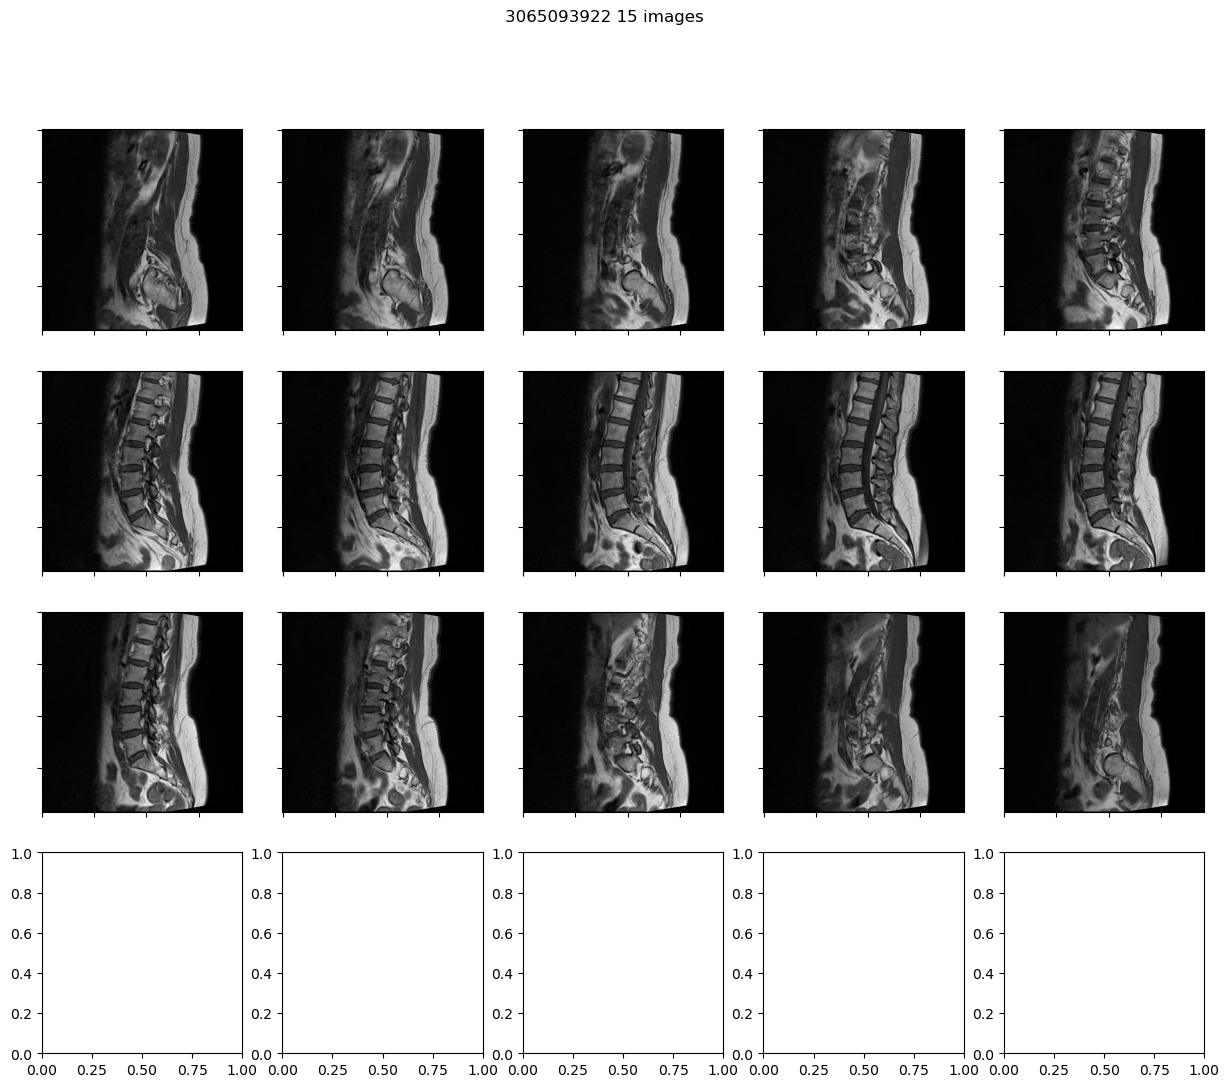

In [75]:
df = files_df[files_df['study_id'] == hfs]

df = df[df['series_description'] == 'Sagittal T1'].sort_values(['proj'], ascending=[True])[:60]

plot_df(df)

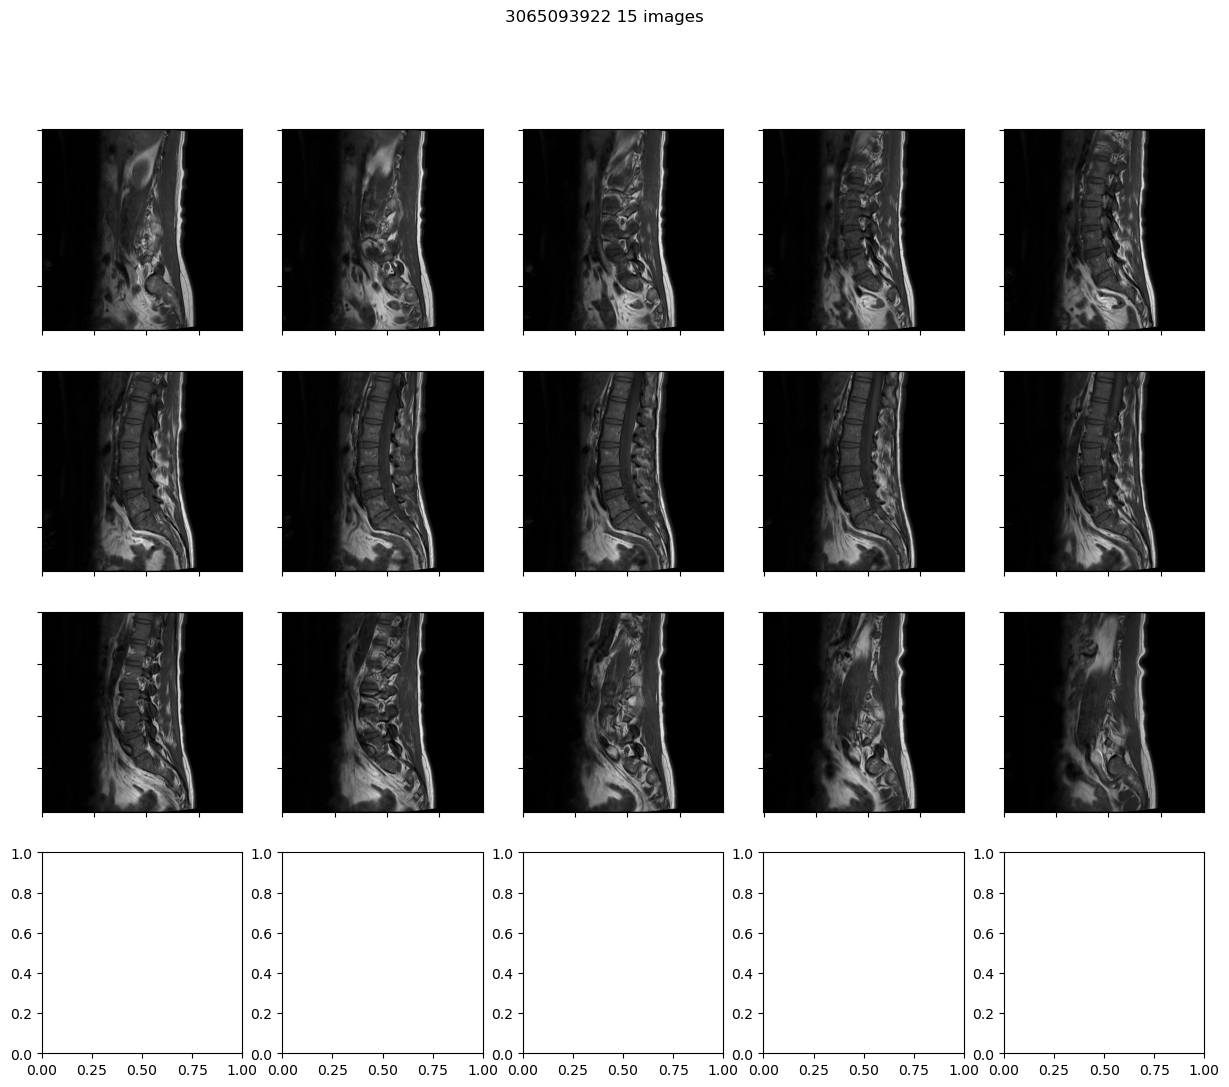

In [76]:
df = files_df[files_df['study_id'] == ffs]

df = df[df['series_description'] == 'Sagittal T1'].sort_values(['proj'], ascending=[False])[:60]

plot_df(df)

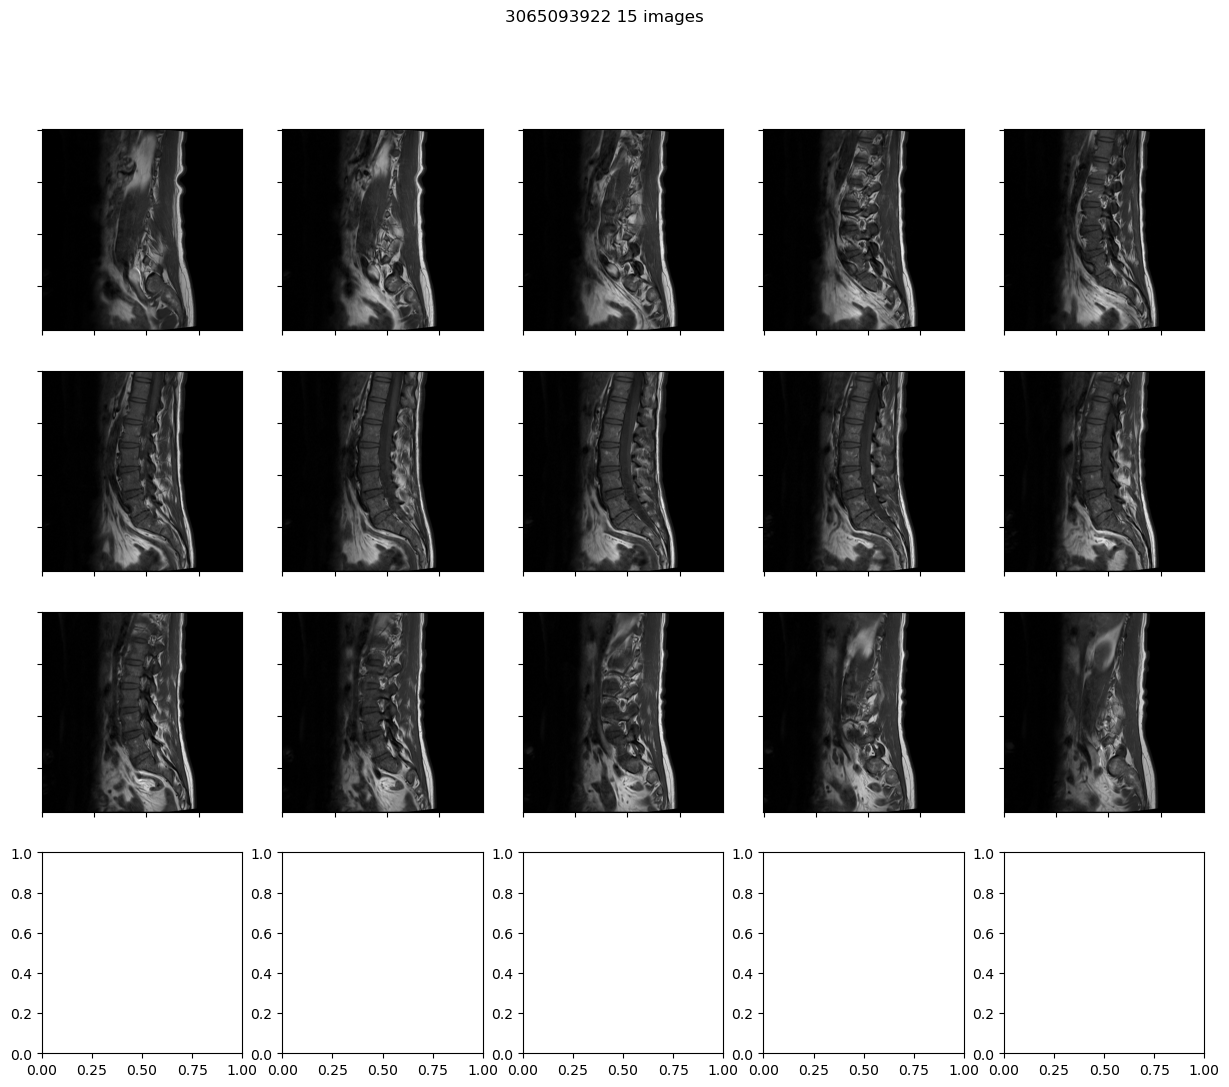

In [77]:
df = files_df[files_df['study_id'] == ffs]

df = df[df['series_description'] == 'Sagittal T1'].sort_values(['proj'], ascending=[True])[:60]

plot_df(df)